# Import Libraries

In [2]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

In [3]:
from choices import param_dict 
from utilities import deets

# Load data

In [21]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',])


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


# Classification

In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test , y_train , y_test = train_test_split(x,y , test_size = 0.2 , stratify=y)

### Using Sklearn API

In [5]:
l = len(y_train)
cl_weight = {}
cl_dict = y_train.value_counts().to_dict()
for cl , val in zip(cl_dict.keys() , cl_dict.values()):
    w = np.exp((l / val)*0.1)
    cl_weight[cl] = w
cl_weight

{'STAR': 1.3179470606104418,
 'AGN': 1.3793432990559484,
 'YSO': 1.9552370229762268,
 'HMXB': 2.8022839541992157,
 'ULX': 38.32697077567007,
 'CV': 102.83057251027365,
 'LMXB': 222.57478508947435,
 'PULSAR': 2013.0523019776572}

In [6]:

train_data = lgb.Dataset(x_train , label=y_train)
test_data = lgb.Dataset(x_test , label=y_test , reference=train_data )
clf = lgb.LGBMClassifier(n_estimators=10 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity=0 , validation_fraction=0.2 ,random_state=42 , num_class = 2)
clf.fit(x_train , y_train ,)
#clf.score(x_test , y_test)

[LightGBM] [Warning] Unknown parameter: validation_fraction
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: validation_fraction
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.


LGBMClassifier(class_weight={'AGN': 1.3793432990559484,
                             'CV': 102.83057251027365,
                             'HMXB': 2.8022839541992157,
                             'LMXB': 222.57478508947435,
                             'PULSAR': 2013.0523019776572,
                             'STAR': 1.3179470606104418,
                             'ULX': 38.32697077567007,
                             'YSO': 1.9552370229762268},
               is_unbalance=True, metric=['auc_mu'], n_estimators=10,
               num_class=2, objective='multiclass', random_state=42,
               sparse=True, validation_fraction=0.2, verbosity=0)

In [7]:
x_test.iloc[0:2]

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J203423.6+405851,5.018995,2.224580,9.650197,0.001888,5.035169,7.5,6.42087,1.0,4.026663e-08,0.002495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.126973,NaN,NaN
2CXO J053505.4-052717,3.908927,5.806955,10.000000,0.008150,10.000000,10.0,10.00000,8.0,9.106110e-10,0.002800,...,5.319602,3.416715,4.484082,NaN,3.870819,NaN,4.116914,3.933575,NaN,NaN


In [8]:
clf.predict(x_test)

array(['YSO', 'STAR', 'AGN', ..., 'AGN', 'STAR', 'YSO'], dtype=object)

In [9]:
pre

NameError: name 'pre' is not defined

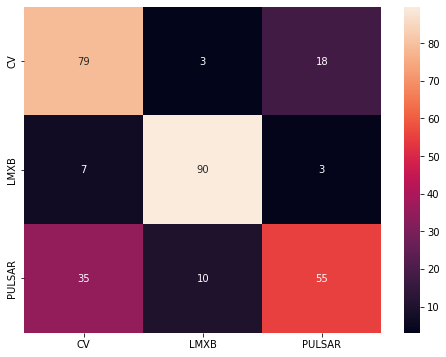

In [ ]:
from sklearn.metrics import confusion_matrix
label = np.unique(y_test)
bst_clf = clf.best_iteration_
cm = confusion_matrix(y_test , clf.predict(x_test) , labels = label , normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(cm*100 , fmt='.0f' , annot=True , xticklabels=label, yticklabels=label)
plt.show()

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier


## Cross validation

In [135]:
from utilities import simple_cv
param = {
    'objective': 'binaryclass',
    'num_class':len(np.unique(y)),
    'metric': ['auc_mu' , ] , 
    'verbosity' : 2 , 
    'deterministic' : True  , 
    'early_stopping_round' : 20 , 
    'sparse' : True , 
    'is_unbalance' : True
    }
l = len(y_train)
cl_weight = {}
cl_dict = y_train.value_counts().to_dict()
for cl , val in zip(cl_dict.keys() , cl_dict.values()):
    w = np.exp((l / val)*0.09)
    cl_weight[cl] = w
cl_weight


{'STAR': 1.2820594649453247,
 'AGN': 1.3356883328329183,
 'YSO': 1.8284347681624522,
 'HMXB': 2.527906031090322,
 'ULX': 26.616689970780907,
 'CV': 64.70085628321034,
 'LMXB': 129.63681917019255,
 'PULSAR': 940.7398749439147}

In [127]:
clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
res_arr = []
from tqdm import tqdm
for i in tqdm(range(1)):
    res = simple_cv(x,y ,model=clf , k=10 , normalize_prob=0)
    print(res['class_scores'].to_markdown())
    res_arr.append(res)

  0%|          | 0/1 [00:00<?, ?it/s]

>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD


  0%|          | 0/1 [00:55<?, ?it/s]


KeyboardInterrupt: 

In [136]:
clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = cl_weight , objective= 'multiclassova', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
res_arr_ova = []
from tqdm import tqdm
for i in tqdm(range(10)):
    res = simple_cv(x,y ,model=clf , k=10 , normalize_prob=0)
    print(res['class_scores'].to_markdown())
    res_arr_ova.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD


 10%|█         | 1/10 [02:30<22:38, 150.95s/it]

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.958664 |          0.975776 |   0.967144 |
| CV      |       0.584337 |          0.505208 |   0.541899 |
| HMXB    |       0.881016 |          0.922969 |   0.901505 |
| LMXB    |       0.811189 |          0.913386 |   0.859259 |
| PULSAR  |       0.524752 |          0.294444 |   0.377224 |
| STAR    |       0.943011 |          0.967991 |   0.955338 |
| ULX     |       0.781991 |          0.629771 |   0.697674 |
| YSO     |       0.939077 |          0.932584 |   0.93582  |
>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD


 20%|██        | 2/10 [05:25<21:59, 164.93s/it]

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.957829 |          0.974511 |   0.966098 |
| CV      |       0.584337 |          0.473171 |   0.522911 |
| HMXB    |       0.872995 |          0.921016 |   0.896362 |
| LMXB    |       0.825175 |          0.914729 |   0.867647 |
| PULSAR  |       0.544554 |          0.300546 |   0.387324 |
| STAR    |       0.941577 |          0.968301 |   0.954752 |
| ULX     |       0.767773 |          0.627907 |   0.690832 |
| YSO     |       0.937337 |          0.934896 |   0.936115 |
>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD


 30%|███       | 3/10 [07:37<17:28, 149.76s/it]

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.955324 |          0.974032 |   0.964587 |
| CV      |       0.590361 |          0.471154 |   0.524064 |
| HMXB    |       0.886364 |          0.933803 |   0.909465 |
| LMXB    |       0.825175 |          0.929134 |   0.874074 |
| PULSAR  |       0.534653 |          0.310345 |   0.392727 |
| STAR    |       0.943369 |          0.968715 |   0.955874 |
| ULX     |       0.781991 |          0.627376 |   0.696203 |
| YSO     |       0.939077 |          0.934199 |   0.936632 |
>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD


 40%|████      | 4/10 [09:54<14:29, 144.90s/it]

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.957411 |          0.972847 |   0.965067 |
| CV      |       0.596386 |          0.521053 |   0.55618  |
| HMXB    |       0.863636 |          0.917614 |   0.889807 |
| LMXB    |       0.825175 |          0.944    |   0.880597 |
| PULSAR  |       0.623762 |          0.321429 |   0.424242 |
| STAR    |       0.942652 |          0.966556 |   0.954455 |
| ULX     |       0.758294 |          0.606061 |   0.673684 |
| YSO     |       0.935596 |          0.938045 |   0.936819 |
>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD


 50%|█████     | 5/10 [12:11<11:49, 141.99s/it]

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.956159 |          0.973639 |   0.96482  |
| CV      |       0.560241 |          0.469697 |   0.510989 |
| HMXB    |       0.882353 |          0.920502 |   0.901024 |
| LMXB    |       0.825175 |          0.929134 |   0.874074 |
| PULSAR  |       0.564356 |          0.293814 |   0.386441 |
| STAR    |       0.941935 |          0.973333 |   0.957377 |
| ULX     |       0.744076 |          0.610895 |   0.67094  |
| YSO     |       0.934726 |          0.927461 |   0.931079 |
>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD


 60%|██████    | 6/10 [14:18<09:07, 136.83s/it]

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.959499 |          0.976626 |   0.967987 |
| CV      |       0.584337 |          0.457547 |   0.513228 |
| HMXB    |       0.881016 |          0.920391 |   0.900273 |
| LMXB    |       0.825175 |          0.967213 |   0.890566 |
| PULSAR  |       0.544554 |          0.307263 |   0.392857 |
| STAR    |       0.941577 |          0.970089 |   0.95562  |
| ULX     |       0.767773 |          0.650602 |   0.704348 |
| YSO     |       0.944299 |          0.932131 |   0.938176 |
>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD


 70%|███████   | 7/10 [16:07<06:23, 127.89s/it]

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.959499 |          0.972493 |   0.965952 |
| CV      |       0.584337 |          0.507853 |   0.543417 |
| HMXB    |       0.879679 |          0.917713 |   0.898294 |
| LMXB    |       0.825175 |          0.914729 |   0.867647 |
| PULSAR  |       0.544554 |          0.303867 |   0.390071 |
| STAR    |       0.941577 |          0.967944 |   0.954578 |
| ULX     |       0.71564  |          0.623967 |   0.666667 |
| YSO     |       0.942559 |          0.928816 |   0.935637 |
>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD


 80%|████████  | 8/10 [17:49<03:59, 119.53s/it]

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.955324 |          0.971963 |   0.963571 |
| CV      |       0.608434 |          0.517949 |   0.559557 |
| HMXB    |       0.881016 |          0.919107 |   0.899659 |
| LMXB    |       0.811189 |          0.935484 |   0.868914 |
| PULSAR  |       0.623762 |          0.331579 |   0.43299  |
| STAR    |       0.941935 |          0.968669 |   0.955115 |
| ULX     |       0.744076 |          0.61811  |   0.675269 |
| YSO     |       0.938207 |          0.932526 |   0.935358 |
>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD


 90%|█████████ | 9/10 [19:37<01:55, 115.77s/it]

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.955324 |          0.971963 |   0.963571 |
| CV      |       0.584337 |          0.487437 |   0.531507 |
| HMXB    |       0.887701 |          0.922222 |   0.904632 |
| LMXB    |       0.832168 |          0.937008 |   0.881481 |
| PULSAR  |       0.613861 |          0.333333 |   0.432056 |
| STAR    |       0.943011 |          0.969418 |   0.956032 |
| ULX     |       0.734597 |          0.630081 |   0.678337 |
| YSO     |       0.939077 |          0.932584 |   0.93582  |
>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD


100%|██████████| 10/10 [21:28<00:00, 128.85s/it]

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.956159 |          0.976962 |   0.966449 |
| CV      |       0.60241  |          0.497512 |   0.544959 |
| HMXB    |       0.874332 |          0.915966 |   0.894665 |
| LMXB    |       0.832168 |          0.937008 |   0.881481 |
| PULSAR  |       0.574257 |          0.300518 |   0.394558 |
| STAR    |       0.941219 |          0.968289 |   0.954562 |
| ULX     |       0.71564  |          0.604    |   0.655098 |
| YSO     |       0.942559 |          0.932014 |   0.937257 |


In [137]:
score_df_ova2 = pd.concat([el['class_scores'] for el in res_arr_ova]).reset_index().sort_values(by='recall_score')
score_df_ova2.to_csv('temp_res_comp/scores/LightGBM_ovaclass_w-0.09.csv')

In [134]:
score_df_ova = pd.concat([el['class_scores'] for el in res_arr_ova]).reset_index().sort_values(by='recall_score')
score_df_ova.to_csv('temp_res_comp/scores/LightGBM_ovaclass_w-0.05.csv')

In [132]:
#score_df = pd.concat([el['class_scores'] for el in res_arr]).reset_index().sort_values(by='recall_score')
#score_df.to_csv('temp_res_comp/scores/LightGBM_allclass.csv')
score_df= pd.read_csv('temp_res_comp/scores/LightGBM_allclass.csv')
score_df

,Unnamed: 0,class,recall_score,precision_score,f1_score
0,12,PULSAR,0.45,0.38,0.41
1,52,PULSAR,0.45,0.37,0.40
2,20,PULSAR,0.46,0.37,0.41
3,28,PULSAR,0.47,0.39,0.43
4,60,PULSAR,0.48,0.38,0.42
...,...,...,...,...,...
75,56,AGN,0.97,0.97,0.97
76,0,AGN,0.97,0.97,0.97
77,64,AGN,0.97,0.97,0.97
78,40,AGN,0.97,0.97,0.97


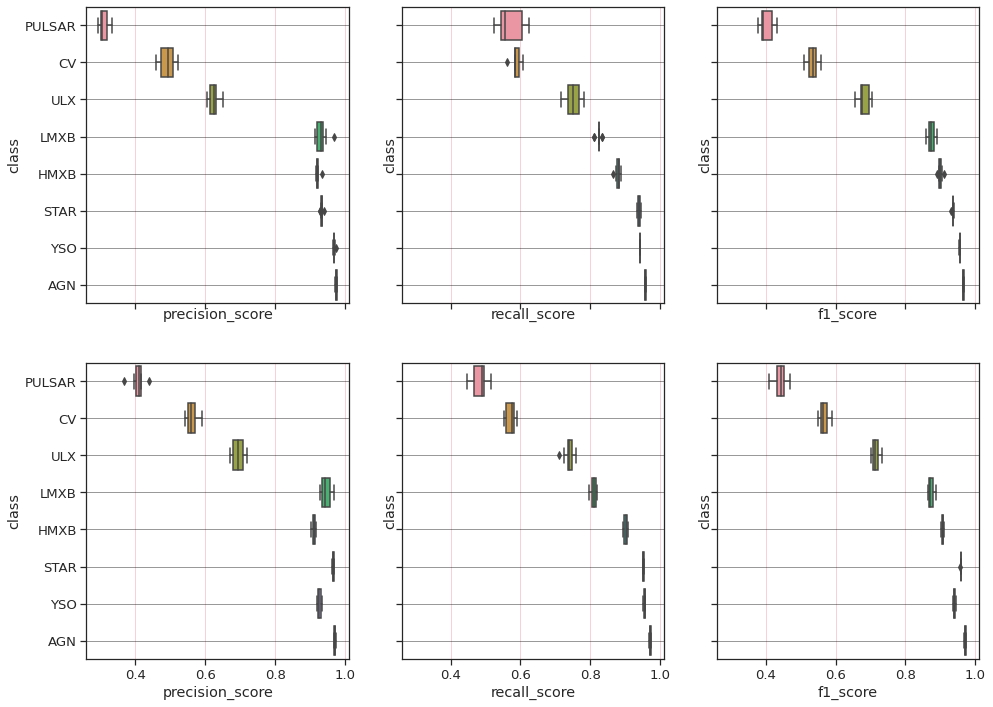

In [138]:
fig , ax = plt.subplots(nrows=2 , ncols=3 , sharey=True ,sharex=True ,  figsize= (16,12))
sns.set_palette('vlag')
sns.boxplot(data = score_df_ova2 ,  y = 'class' , x = 'precision_score' , ax=ax[0][0])
sns.boxplot(data = score_df_ova2 ,  y = 'class' , x = 'recall_score' , ax=ax[0][1])
sns.boxplot(data = score_df_ova2 ,  y = 'class' , x = 'f1_score' , ax=ax[0][2])

sns.boxplot(data = score_df_ova ,  y = 'class' , x = 'precision_score' , ax=ax[1][0])
sns.boxplot(data = score_df_ova ,  y = 'class' , x = 'recall_score' , ax=ax[1][1])
sns.boxplot(data = score_df_ova ,  y = 'class' , x = 'f1_score' , ax=ax[1][2])
for ai in ax:
    for a in ai:
        a.yaxis.grid(True, color ="black" , alpha=0.4)
        a.xaxis.grid(True , color='crimson' , alpha=0.2)
#plt.savefig()
plt.show()

In [68]:
res['res_table']

,true_class,pred_class,pred_prob,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J231447.3+043206,HMXB,HMXB,0.98,0.01,0.00,0.98,0.00,0.01,0.00,0.00,0.00
2CXO J022525.6-043509,AGN,AGN,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2CXO J203258.5+410540,YSO,YSO,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2CXO J032509.3+304620,STAR,STAR,0.82,0.00,0.00,0.18,0.00,0.00,0.82,0.00,0.00
2CXO J085408.0+502941,AGN,AGN,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J213727.2+573129,STAR,STAR,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2CXO J145357.9+033237,HMXB,HMXB,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
2CXO J034437.3+320611,STAR,STAR,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [56]:
pd.options.display.float_format = '{:,.2f}'.format
class_scores = res['class_scores']
print(class_scores.to_markdown())

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.97453  |          0.967261 |   0.970882 |
| CV      |       0.560241 |          0.57764  |   0.568807 |
| HMXB    |       0.890374 |          0.91358  |   0.901828 |
| LMXB    |       0.797203 |          0.919355 |   0.853933 |
| PULSAR  |       0.435644 |          0.4      |   0.417062 |
| STAR    |       0.953763 |          0.959611 |   0.956678 |
| ULX     |       0.7109   |          0.688073 |   0.699301 |
| YSO     |       0.944299 |          0.923404 |   0.933735 |


In [45]:
res

{'classes': array(['AGN', 'CV', 'HMXB', 'LMXB', 'PULSAR', 'STAR', 'ULX', 'YSO'],
       dtype=object),
 'num_src':         pred_class
 STAR          2178
 AGN           1913
 YSO           1226
 HMXB          1202
 CV             492
 ULX            422
 LMXB           167
 PULSAR         103,
 'balanced_accuracy': 0.6774596217642022,
 'accuracy': 0.7615214851356614,
 'precision': 0.8391267185000693,
 'recall': 0.7615214851356614,
 'f1': 0.7851210214555311,
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN             0.77             0.96      0.86
 CV              0.53             0.18      0.27
 HMXB            0.85             0.53      0.65
 LMXB            0.76             0.65      0.70
 PULSAR          0.28             0.27      0.27
 STAR            0.74             0.94      0.83
 ULX             0.66             0.33      0.44
 YSO             0.84             0.79      0.82,
 'res_table':                  

Text(0.5, 1.0, 'CF for LighgGBM,')

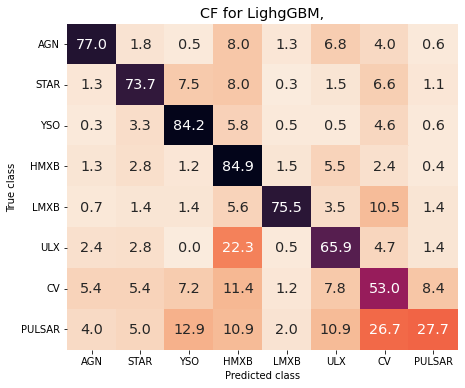

In [46]:
from utilities import plot_cf
plot_dict_def = {
    'title' : False , 
    'font_scale' : 1.2 ,
    'cbar' : False ,
    'plot_num' : 0,
}
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(7,6))
plot_cf([res['res_table']] , plot_dict=plot_dict_def , confidance=0. , ax=ax)
plt.title('CF for LighgGBM,')
#plt.savefig('temp_res_comp/cf/lightGBM_rf.png')

In [12]:
res['res_table'].to_csv('temp_res_comp/train_prob_dist/lightGBM.csv')

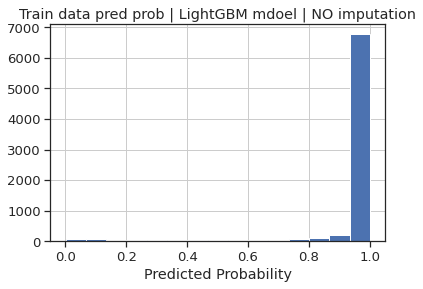

In [64]:
plt.hist(res['res_table']['pred_prob'] , bins=15)
plt.title('Train data pred prob | LightGBM mdoel | NO imputation')
plt.xlabel('Predicted Probability')
#plt.savefig('temp_res_comp/train_prob_dist/LightGBM_prob.jpg')
plt.show()

### Prediction on New sources

In [65]:
from utilities import softmax , norm_prob
clf = res['clf']
pred_prob = (clf.predict_proba(u))
pred_prob_df = pd.DataFrame(pred_prob , columns=[f'prob_{el}' for el in clf.classes_] , index = u.index.to_list())
pred_prob_df

,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
2CXO J004829.5-732959,0.01,0.78,1.00,0.00,0.77,0.02,0.01,0.00
2CXO J005449.0-725128,0.03,0.19,0.67,0.00,0.06,0.03,0.00,0.00
2CXO J010049.1-731526,0.01,0.41,0.61,0.00,0.69,0.13,0.01,0.00
2CXO J010049.8-731045,0.01,0.17,0.41,0.00,0.51,0.04,0.00,0.00
2CXO J010647.7-730940,0.00,0.76,0.96,0.00,0.55,0.19,0.00,0.00
...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,0.05,0.99,0.00,0.00,0.06,0.03,0.06,0.00
2CXO J220508.3-495935,0.01,0.96,0.01,0.00,0.04,0.01,0.14,0.00
2CXO J220544.0-495505,0.22,0.41,0.02,0.00,0.00,0.03,0.01,0.00
2CXO J220555.6-500837,0.00,0.11,0.47,0.00,0.00,0.00,0.06,0.00


In [66]:
u_df = pd.DataFrame({
    'name' : u.index.to_list() , 
    'class' : clf.predict(u) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index=True)
u_df.index.name = 'name'
u_df 

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,HMXB,1.00,0.21,0.01,0.78,1.00,0.00,0.77,0.02,0.01,0.00
2CXO J005449.0-725128,HMXB,0.67,0.48,0.03,0.19,0.67,0.00,0.06,0.03,0.00,0.00
2CXO J010049.1-731526,PULSAR,0.69,0.08,0.01,0.41,0.61,0.00,0.69,0.13,0.01,0.00
2CXO J010049.8-731045,PULSAR,0.51,0.10,0.01,0.17,0.41,0.00,0.51,0.04,0.00,0.00
2CXO J010647.7-730940,HMXB,0.96,0.21,0.00,0.76,0.96,0.00,0.55,0.19,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,CV,0.99,0.92,0.05,0.99,0.00,0.00,0.06,0.03,0.06,0.00
2CXO J220508.3-495935,CV,0.96,0.82,0.01,0.96,0.01,0.00,0.04,0.01,0.14,0.00
2CXO J220544.0-495505,CV,0.41,0.19,0.22,0.41,0.02,0.00,0.00,0.03,0.01,0.00


In [67]:
u_df.to_csv('temp_res_comp/unid_prob/lightGBM.csv')

In [68]:
u_df = pd.read_csv('temp_res_comp/unid_prob/lightGBM.csv' , index_col='name')
u_df

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,HMXB,1.00,0.21,0.01,0.78,1.00,0.00,0.77,0.02,0.01,0.00
2CXO J005449.0-725128,HMXB,0.67,0.48,0.03,0.19,0.67,0.00,0.06,0.03,0.00,0.00
2CXO J010049.1-731526,PULSAR,0.69,0.08,0.01,0.41,0.61,0.00,0.69,0.13,0.01,0.00
2CXO J010049.8-731045,PULSAR,0.51,0.10,0.01,0.17,0.41,0.00,0.51,0.04,0.00,0.00
2CXO J010647.7-730940,HMXB,0.96,0.21,0.00,0.76,0.96,0.00,0.55,0.19,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,CV,0.99,0.92,0.05,0.99,0.00,0.00,0.06,0.03,0.06,0.00
2CXO J220508.3-495935,CV,0.96,0.82,0.01,0.96,0.01,0.00,0.04,0.01,0.14,0.00
2CXO J220544.0-495505,CV,0.41,0.19,0.22,0.41,0.02,0.00,0.00,0.03,0.01,0.00


In [69]:
u_df_th = u_df[u_df['prob']>0.9]
print(u_df_th['class'].value_counts().to_markdown())

|        |   class |
|:-------|--------:|
| STAR   |    6137 |
| AGN    |    5039 |
| YSO    |    4757 |
| HMXB   |    2830 |
| PULSAR |    1953 |
| ULX    |    1107 |
| CV     |     824 |
| LMXB   |     155 |


In [70]:
from numpy.random import normal
from ridgeplot import ridgeplot
cl = classes[::-1]
sample = [u_df[u_df['class']==c]['prob'] for c in cl]
fig = ridgeplot(
    samples=sample,
    kde_points=np.linspace(0, 1, 500),
    colorscale="inferno",
    colormode="index",
    coloralpha=0.6,
    labels=cl,
    spacing = 3 / 8,
    xpad=0
)
fig.update_layout(
    title="Unidentified sources | No Imputation | LightGBM classifier",
    height=550,
    width=600,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    xaxis_title="Predicted Probability",
    yaxis_title="Predicted Probability Density",
)

#fig.save('temp.png')
fig.write_image('temp_res_comp/unid_prob_dist/lightGBM.jpg')
fig.show()

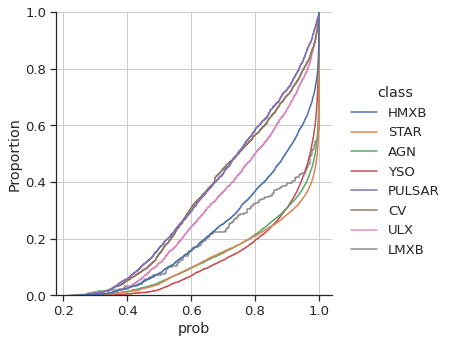

In [39]:
sns.displot(
    data = u_df ,
    kind='ecdf' ,
    x = 'prob' ,
    hue = 'class'
)
#plt.savefig('plots/higher_models/lbg_unid_prob.jpg')
plt.show()